In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import seaborn as sns

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import spacy


import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from tensorflow import random_normal_initializer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout, Reshape, Activation
import tensorflow.keras as keras
from collections import Counter
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid, RandomizedSearchCV
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from mlxtend.regressor import StackingCVRegressor

from catboost import CatBoostRegressor
from itertools import product, chain
from tqdm import tqdm
import math  

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time
import shap 

import os
import tensorflow as tf
import random 

c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data_path = 'data/train_data.csv'
test_data_path = 'data/test_data.csv'


train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [3]:
train_df.sample(5)
o_train_df = train_df

In [4]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


In [5]:
train_df.isnull().sum()


Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [6]:
#Dealing with continous variables
train_df.describe().round(2)

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000,7160.000,7160.000,7054.000,7160.000,6652.000,7160.000
mean,2013.670,0.910,0.310,1883.730,2.190,1964.460,0.230
std,1.380,0.240,0.460,2278.160,0.940,36.000,0.420
min,2012.000,0.000,0.000,1.000,1.000,1545.000,0.000
25%,2012.000,1.000,0.000,528.000,2.000,1960.000,0.000
50%,2013.000,1.000,0.000,1083.000,2.000,1970.000,0.000
75%,2015.000,1.000,1.000,2289.750,3.000,1980.000,0.000
max,2016.000,1.000,1.000,20940.000,4.000,2016.000,1.000


In [7]:
#Duplicate Values
train_df.duplicated().sum()


0

Editing the dataset (changing the value types)

In [8]:
train_df['Date_of_Occupancy'] = train_df['Date_of_Occupancy'].fillna(train_df['Date_of_Occupancy'].median())
train_df['Building Dimension'] = train_df['Building Dimension'].fillna(train_df['Building Dimension'].median())
train_df['Garden'] = train_df['Garden'].fillna(train_df['Garden'].mode()[0])
train_df['Geo_Code'] = train_df['Geo_Code'].fillna(train_df['Geo_Code'].mode()[0])


In [9]:
#Encoding of categorical variables We use Label Encoder
train_df['Building_Painted'] = train_df['Building_Painted'].replace(['N','V'],[1,0])
train_df['Building_Fenced'] = train_df['Building_Fenced'].replace(['N','V'],[1,0])
train_df['Garden'] = train_df['Garden'].replace(['V','O'],[1,0])
train_df['Settlement'] = train_df['Settlement'].replace(['R','U'],[0,1])
train_df['Building_Type'] = train_df['Building_Type'].replace([1,2,3,4],[0,1,2,3])

In [10]:
train_df['NumberOfWindows'] = train_df['NumberOfWindows'].replace(['   .','>=10'],['',10])
train_df['NumberOfWindows'] = train_df['NumberOfWindows'].replace(['','1','2','3','4','5','6','7','8','9',10],[0,1,2,3,4,5,6,7,8,9,10])


In [15]:

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler,SMOTE
train_df = train_df.drop('Customer Id',axis=1)
train_df = train_df.drop('Geo_Code',axis=1)
X = train_df.drop('Claim', axis = 1)
y = train_df['Claim']

# ros = RandomOverSampler(random_state=2)
# X,y = ros.fit_resample(X,y)

# # Combine X_resampled and y_resampled into a new DataFrame
# train_df_resampled = pd.DataFrame(X, columns=X.columns)
# train_df_resampled['Claim'] = y

# train_df = train_df_resampled

**EXPLORATORY DATA ANALYSIS**

UNIVARIATE ANALYSIS

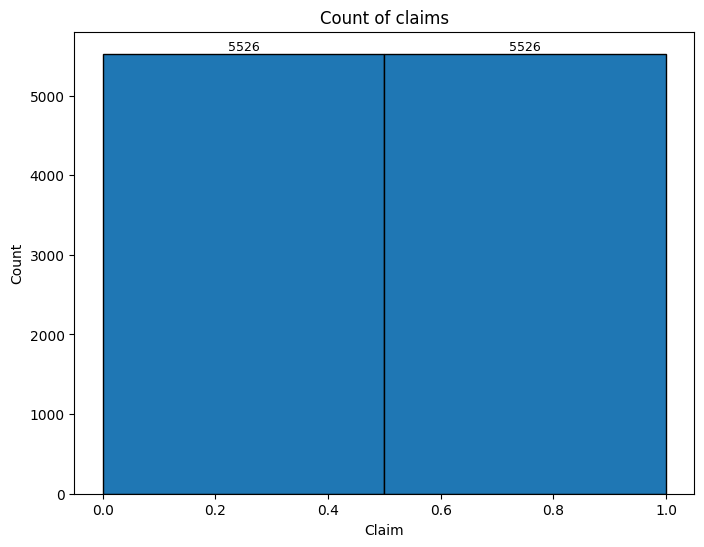

In [13]:

data = train_df['Claim']

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(data, bins=2, edgecolor='black')
# Annotate each bar with its count
hist_values, bin_edges = np.histogram(data, bins=2)
for i in range(len(hist_values)):
    plt.text(bin_edges[i] + (bin_edges[i+1] - bin_edges[i]) / 2, hist_values[i] + 2,
             str(hist_values[i]), ha='center', va='bottom', fontsize=9)

plt.title('Count of claims')
plt.xlabel('Claim')
plt.ylabel('Count')

plt.show()

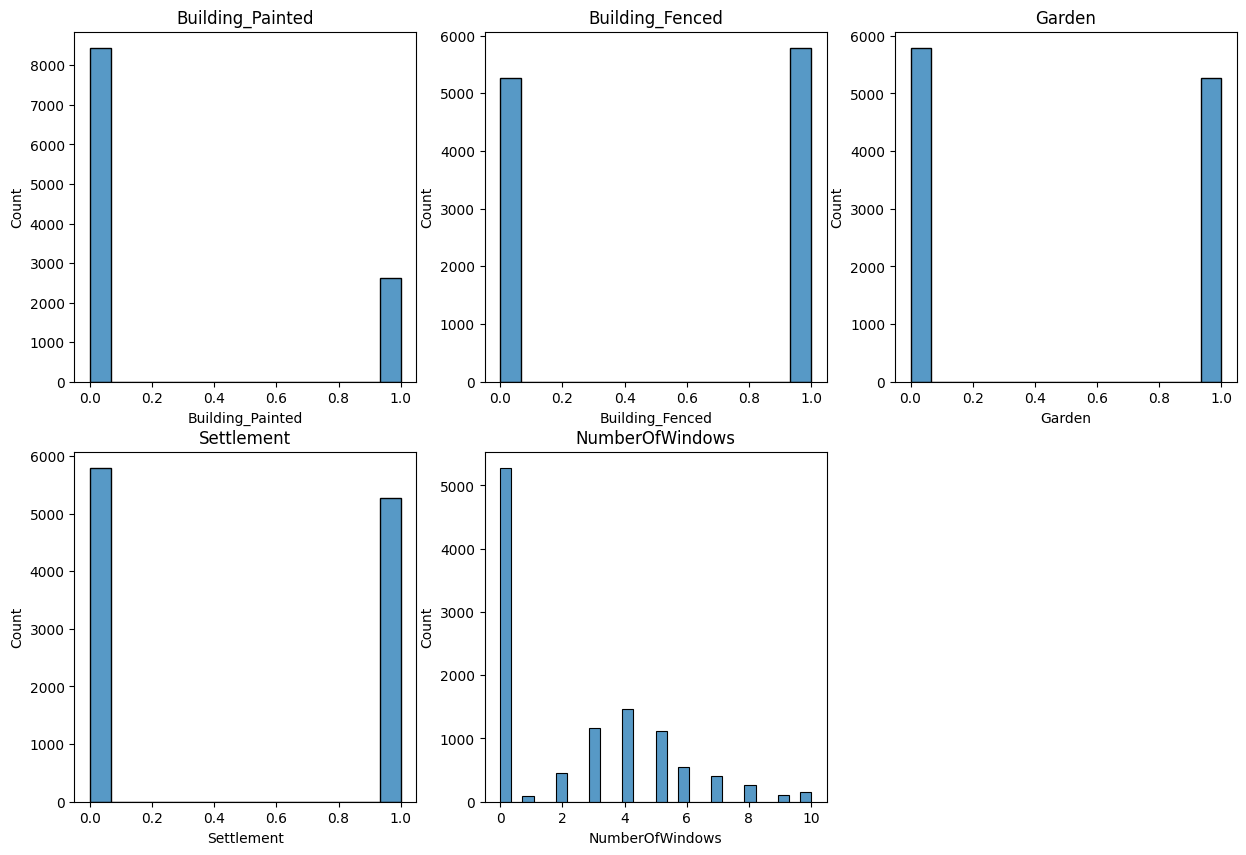

In [14]:
#Categorical Variables
train_cat = ['Building_Painted','Building_Fenced','Garden','Settlement','NumberOfWindows',]

#  plot Numerical Data
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(15,10))

for i in train_cat:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    #plt.xlabel(i)
    sns.histplot(train_df[i])
    c = c + 1

plt.show()

C:\Users\Prachet.balaji\AppData\Local\Temp\ipykernel_21320\538211219.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[i])
C:\Users\Prachet.balaji\AppData\Local\Temp\ipykernel_21320\538211219.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[i])


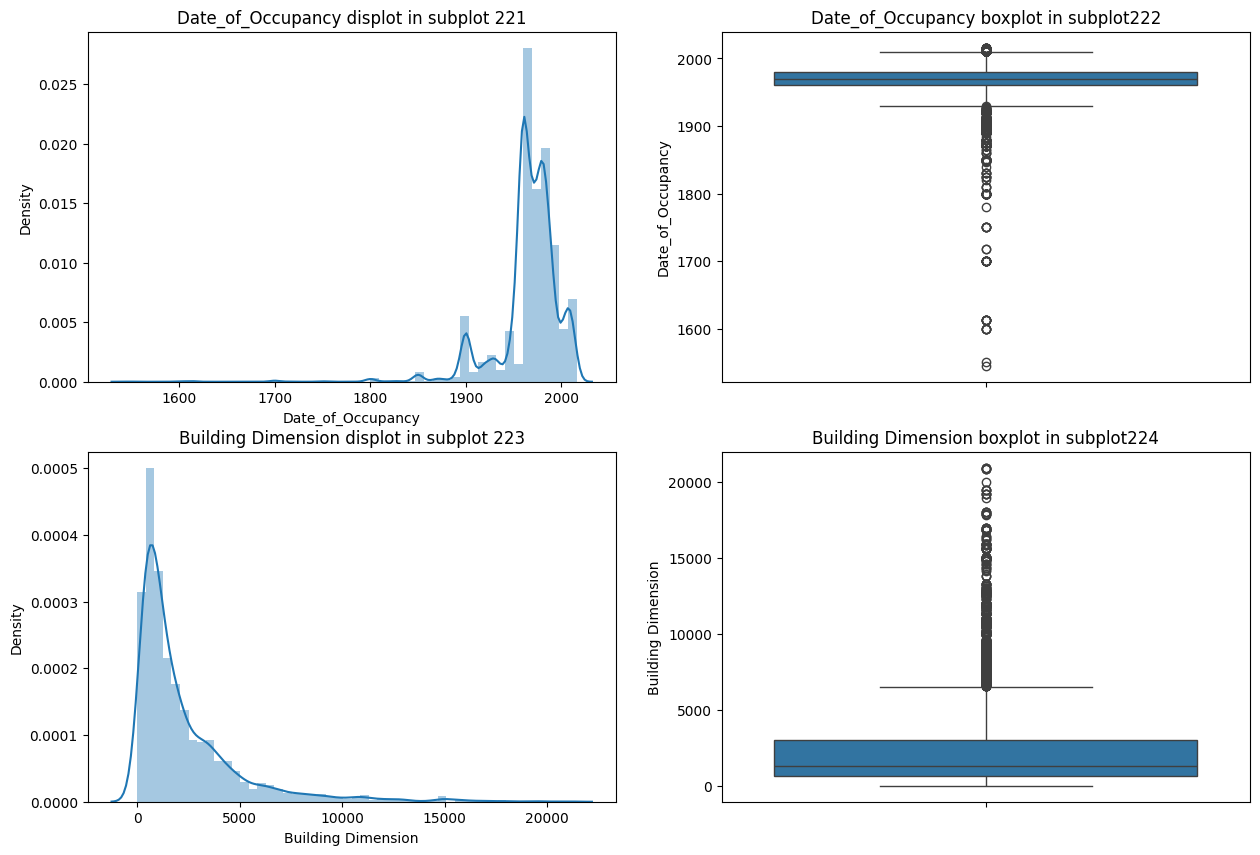

In [15]:
train_num = ['Date_of_Occupancy','Building Dimension']

a = 2
b = 2
c = 1
plt.figure(figsize=(15,10))
for i in train_num:
    plt.subplot(a,b,c)
    plt.title("{} displot in subplot {}{}{}".format(i,a,b,c))
    sns.distplot(train_df[i])
    c = c + 1

    plt.subplot(a,b,c)
    plt.title("{} boxplot in subplot{}{}{}".format(i,a,b,c))
    sns.boxplot(train_df[i])
    c = c + 1

Bivaraite Analysis

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11052 entries, 0 to 11051
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearOfObservation   11052 non-null  int64  
 1   Insured_Period      11052 non-null  float64
 2   Residential         11052 non-null  int64  
 3   Building_Painted    11052 non-null  int64  
 4   Building_Fenced     11052 non-null  int64  
 5   Garden              11052 non-null  int64  
 6   Settlement          11052 non-null  int64  
 7   Building Dimension  11052 non-null  float64
 8   Building_Type       11052 non-null  int64  
 9   Date_of_Occupancy   11052 non-null  float64
 10  NumberOfWindows     11052 non-null  int64  
 11  Claim               11052 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.0 MB


In [17]:
train_df_corr = train_df
train_df_corr

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Claim
0,2013,1.000,0,1,0,1,1,290.000,0,1960.000,0,0
1,2015,1.000,0,0,1,0,0,490.000,0,1850.000,4,0
2,2014,1.000,0,1,0,1,1,595.000,0,1960.000,0,0
3,2013,1.000,0,0,0,1,1,2840.000,0,1960.000,0,0
4,2014,1.000,0,0,1,0,0,680.000,0,1800.000,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11047,2012,1.000,0,0,0,1,1,3140.000,0,1980.000,0,1
11048,2012,0.915,0,0,1,0,0,280.000,3,1940.000,2,1
11049,2012,1.000,1,0,1,0,0,4909.000,1,2010.000,5,1
11050,2015,1.000,1,0,1,0,0,3732.000,3,1930.000,8,1


<Axes: >

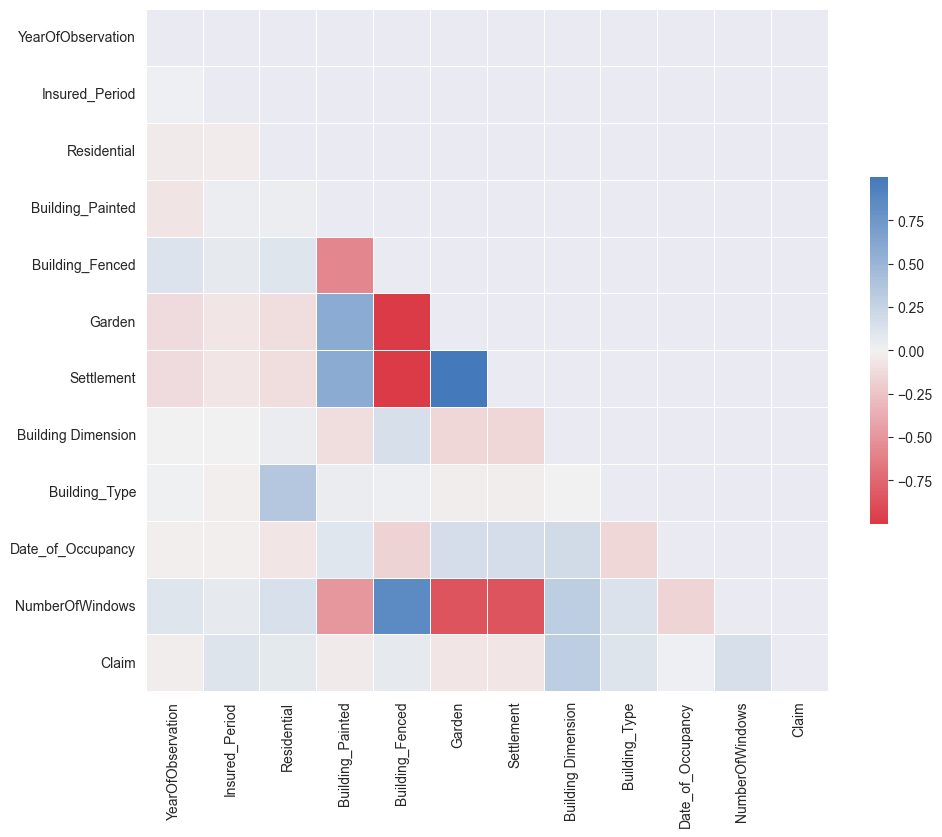

In [18]:

import seaborn as sns
# use the pandas .corr() function to compute pairwise correlations for the dataframe
corr = train_df_corr.corr()
# visualise the data with seaborn
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'dark')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [12]:
X = train_df.drop('Claim', axis = 1)
y = train_df['Claim']


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [21]:
train_df

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Claim
0,2013,1.000,0,1,0,1,1,290.000,0,1960.000,0,0
1,2015,1.000,0,0,1,0,0,490.000,0,1850.000,4,0
2,2014,1.000,0,1,0,1,1,595.000,0,1960.000,0,0
3,2013,1.000,0,0,0,1,1,2840.000,0,1960.000,0,0
4,2014,1.000,0,0,1,0,0,680.000,0,1800.000,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11047,2012,1.000,0,0,0,1,1,3140.000,0,1980.000,0,1
11048,2012,0.915,0,0,1,0,0,280.000,3,1940.000,2,1
11049,2012,1.000,1,0,1,0,0,4909.000,1,2010.000,5,1
11050,2015,1.000,1,0,1,0,0,3732.000,3,1930.000,8,1


In [22]:
X_train

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows
1502,2012,1.000,0,1,0,1,1,1410.000,1,1960.000,0
4089,2015,1.000,0,1,0,1,1,1754.000,2,1960.000,0
10531,2012,1.000,0,1,0,1,1,2335.000,2,1960.000,0
4602,2012,1.000,0,0,0,1,1,1387.000,0,1988.000,0
4567,2014,1.000,0,0,0,1,1,450.000,0,1988.000,0
...,...,...,...,...,...,...,...,...,...,...,...
4859,2013,1.000,0,1,0,1,1,2290.000,0,1980.000,0
3264,2014,1.000,0,0,1,0,0,4500.000,0,1962.000,10
9845,2014,1.000,0,0,0,1,1,1455.000,1,1960.000,0
10799,2014,1.000,0,0,1,0,0,660.000,0,2005.000,3


In [23]:

features = train_df.columns.tolist()
features.remove('Claim')

features

['YearOfObservation',
 'Insured_Period',
 'Residential',
 'Building_Painted',
 'Building_Fenced',
 'Garden',
 'Settlement',
 'Building Dimension',
 'Building_Type',
 'Date_of_Occupancy',
 'NumberOfWindows']

In [24]:
from scipy.stats import pointbiserialr
from math import sqrt

def getMerit(subset, label):
    k = len(subset)

    # average feature-class correlation
    rcf_all = []
    for feature in subset:
        coeff = pointbiserialr(train_df[label], train_df[feature] )
        rcf_all.append( abs( coeff.correlation ) )
    rcf = np.mean( rcf_all )

    # average feature-feature correlation
    corr = train_df[subset].corr()
    corr.values[np.tril_indices_from(corr.values)] = np.nan
    corr = abs(corr)
    rff = corr.unstack().mean()

    return (k * rcf) / sqrt(k + k * (k-1) * rff)

In [25]:
best_value = -1
best_feature = ''
for feature in features:
    coeff = pointbiserialr(y_train, X_train[feature] )
    abs_coeff = abs( coeff.correlation )
    if abs_coeff > best_value:
        best_value = abs_coeff
        best_feature = feature

print("Feature %s with merit %.4f"%(best_feature, best_value))


Feature Building Dimension with merit 0.2988


In [26]:
class PriorityQueue:
    def  __init__(self):
        self.queue = []

    def isEmpty(self):
        return len(self.queue) == 0
    
    def push(self, item, priority):
        """
        item already in priority queue with smaller priority:
        -> update its priority
        item already in priority queue with higher priority:
        -> do nothing
        if item not in priority queue:
        -> push it
        """
        for index, (i, p) in enumerate(self.queue):
            if (set(i) == set(item)):
                if (p >= priority):
                    break
                del self.queue[index]
                self.queue.append( (item, priority) )
                break
        else:
            self.queue.append( (item, priority) )
        
    def pop(self):
        # return item with highest priority and remove it from queue
        max_idx = 0
        for index, (i, p) in enumerate(self.queue):
            if (self.queue[max_idx][1] < p):
                max_idx = index
        (item, priority) = self.queue[max_idx]
        del self.queue[max_idx]
        return (item, priority)

In [27]:
# initialize queue
queue = PriorityQueue()

# push first tuple (subset, merit)
queue.push([best_feature], best_value)

In [28]:
# list for visited nodes
visited = []

# counter for backtracks
n_backtrack = 0

# limit of backtracks
max_backtrack = 100


In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11052 entries, 0 to 11051
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearOfObservation   11052 non-null  int64  
 1   Insured_Period      11052 non-null  float64
 2   Residential         11052 non-null  int64  
 3   Building_Painted    11052 non-null  int64  
 4   Building_Fenced     11052 non-null  int64  
 5   Garden              11052 non-null  int64  
 6   Settlement          11052 non-null  int64  
 7   Building Dimension  11052 non-null  float64
 8   Building_Type       11052 non-null  int64  
 9   Date_of_Occupancy   11052 non-null  float64
 10  NumberOfWindows     11052 non-null  int64  
 11  Claim               11052 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.0 MB


In [30]:
# repeat until queue is empty
# # or the maximum number of backtracks is reached

# while not queue.isEmpty():
#     # get element of queue with highest merit
#     subset, priority = queue.pop()
    
#     # check whether the priority of this subset
#     # is higher than the current best subset
#     if (priority < best_value):
#         n_backtrack += 1
#     else:
#         best_value = priority
#         best_subset = subset

#     # goal condition
#     if (n_backtrack == max_backtrack):
#         break
    
#     # iterate through all features and look of one can
#     # increase the merit
#     for feature in features:
#         if feature not in subset:
#             temp_subset = subset + [feature]
        
#         # check if this subset has already been evaluated
#         for node in visited:
#             if (set(node) == set(temp_subset)):
#                 break
#         # if not, ...
#         else:
#             # ... mark it as visited
#             visited.append( temp_subset )
#             # ... compute merit
#             merit = getMerit(temp_subset, 'Claim')
#             # print(merit)
#             # print(temp_subset)

            
#             # and push it to the queue
#             queue.push(temp_subset, merit)





# Ensure queue and visited are properly initialized
# Assume visited is a set to store frozensets of subsets for fast lookup

best_value = float('-inf')  # Initialize with a very low value
best_subset = ['Building Dimension']
n_backtrack = 0
max_backtrack = 10000  # Set to your desired max backtracks


visited = set()
queue = PriorityQueue()

# Initialize the queue with the best feature (assuming best_feature is already determined)
initial_subset = best_subset
initial_merit = getMerit(initial_subset, 'Claim')
queue.push(initial_subset, initial_merit)
visited.add(frozenset(initial_subset))

# Repeat until queue is empty or the maximum number of backtracks is reached
while not queue.isEmpty():
    # Get element of queue with highest merit
    subset, priority = queue.pop()
    
    # Check whether the priority of this subset is higher than the current best subset
    if priority < best_value:
        n_backtrack += 1
    else:
        best_value = priority
        best_subset = subset

    # Goal condition
    if n_backtrack == max_backtrack:
        break
    
    # Iterate through all features and check if one can increase the merit
    for feature in features:
        if feature not in subset:
            temp_subset = subset + [feature]
            temp_frozenset = frozenset(temp_subset)
        
            # Check if this subset has already been evaluated
            if temp_frozenset not in visited:
                # Mark it as visited
                visited.add(temp_frozenset)
            
                # Compute merit
                merit = getMerit(temp_subset, 'Claim')
                print(merit)
                # Push it to the queue
                queue.push(temp_subset, merit)

# Return the best subset based on the best merit
print("Best Subset:", best_subset)
print("Best Merit Value:", best_value)


# Best Subset: ['Building_Type', 'Building Dimension']
# Best Merit Value: 0.2869903439496809

0.2294456559576706
0.28904834278752695
0.2554367196503671
0.2267611458899617
0.2376740791070932
0.2380498279687428
0.23793912055605534
0.28972406228837294
0.20418021222951752
0.2791082422502159
0.2531187306299351
0.30123419880159413
0.24883477756318126
0.2494663588725213
0.2596356278908199
0.25995530601224826
0.25986660006406315
0.22424804237415819
0.2880563865818402
0.274279316964851
0.271032754302352
0.27063242081067734
0.2776634331822716
0.27792524768076066
0.27787883682882264
0.25019325984293905
0.3038501332243074
0.2836769735986353
0.2820532751845094
0.26641462386839687
0.26050644041253207
0.2606503412707661
0.26061217394501746
0.2641153114598612
0.25195650363989974
0.27224132635360065
0.2493516045191462
0.2563713230696663
0.25666230084536273
0.25660831761740593
0.23254190790796214
0.2924844525181848
0.26696850721850146
0.2809757149970213
0.24801484167076662
0.2407836957224219
0.2409358212777073
0.24089280391682458
0.250661034945699
0.2644021409228395
0.2626802996361962
0.24553272

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
import time

# predictors
X_train_svm_o = X_train[features].to_numpy()
# target
y_train_svm_o = y_train.to_numpy()

# get timing
t0 = time.time()

# run SVM with 10-fold cross validation
svc = svm.SVC(kernel='rbf', C=100, gamma=0.01, random_state=42)
scores = cross_val_score(svc, X_train_svm_o, y_train_svm_o, cv=10)
best_score = np.mean( scores )

print("Score: %.2f%% (Time: %.4f s)"%(best_score*100, time.time() - t0))

# Output
# Score: 67.65 Time 48 s

Score: 82.16% (Time: 50.9310 s)


In [31]:
X_train

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows
1502,2012,1.000,0,1,0,1,1,1410.000,1,1960.000,0
4089,2015,1.000,0,1,0,1,1,1754.000,2,1960.000,0
10531,2012,1.000,0,1,0,1,1,2335.000,2,1960.000,0
4602,2012,1.000,0,0,0,1,1,1387.000,0,1988.000,0
4567,2014,1.000,0,0,0,1,1,450.000,0,1988.000,0
...,...,...,...,...,...,...,...,...,...,...,...
4859,2013,1.000,0,1,0,1,1,2290.000,0,1980.000,0
3264,2014,1.000,0,0,1,0,0,4500.000,0,1962.000,10
9845,2014,1.000,0,0,0,1,1,1455.000,1,1960.000,0
10799,2014,1.000,0,0,1,0,0,660.000,0,2005.000,3


In [47]:
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC 
from sklearn import svm

# # predictors
# X= X_train[best_subset].to_numpy()
# Y = y_train
# X_t = X_test[best_subset].to_numpy()
# y_t = y_test
# get timing
t0 = time.time()

# run SVM with 10-fold cross validation
svc = svm.SVC(kernel='rbf', C=1000, gamma=1, random_state=60)
scores_subset = cross_val_score(svc, X, y, cv=10)
best_score = np.mean( scores_subset )

# print("Score: %.2f%% (Time: %.4f s)"%(best_score*100, time.time() - t0))
# # print prediction results 
# svc.fit(X,Y)
# predictions = svc.predict(X_t) 
# print(classification_report(y_t, predictions)) 
# # Output
# Score: 75.73 Time 36 s c =10 rbf g = 0.01 and rs = 60
# Score : 76.9 Time 4 s kernel='sigmoid', C=10, gamma=0.1, random_state=60 // not valid since 0 recall and precision on one class(overfitting on one class)

KeyboardInterrupt: 

In [48]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1,0.5, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
grid.fit(X, y) 
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(X) 
  
# print classification report 
print(classification_report(y, grid_predictions)) 


###AFTER HYPERPARAMETER TUNING : {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.772 total time=   3.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.772 total time=   3.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.772 total time=   3.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.772 total time=   3.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.772 total time=   3.4s
[CV 1/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.772 total time=   4.9s
[CV 2/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.772 total time=   3.3s
[CV 3/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.772 total time=   3.4s
[CV 4/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.772 total time=   5.0s
[CV 5/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.772 total time=   3.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.772 total time=   3.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

KeyboardInterrupt: 

In [34]:
from sklearn.ensemble import RandomForestClassifier
# predictors
X= X_train[best_subset].to_numpy()
Y = y_train
X_t = X_test[best_subset].to_numpy()
y_t = y_test
#Random Forest Classifier with 10 fold estimators
rfc = RandomForestClassifier(n_estimators=10000)
rfc_fit = rfc.fit(X, Y)
rfc_predicted = rfc.predict(X_t)
rfc_probs = rfc.predict_proba(X_t)[:, 1]

In [35]:
from sklearn.metrics import roc_auc_score
# calculate roc auc
rfc_roc_value = roc_auc_score(y_t, rfc_probs)
rfc_roc_value


0.8755146751577149

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix 
print(classification_report(y_t,rfc_predicted))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1660
           1       0.38      0.26      0.31       488

    accuracy                           0.73      2148
   macro avg       0.59      0.57      0.57      2148
weighted avg       0.70      0.73      0.72      2148



**Stacking Classifier**

In [17]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Define the base learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=10000, random_state=42)),
    ('svm', SVC(kernel='rbf', C=1000, gamma=1, random_state=60, probability=True)),
    ('gbc', GradientBoostingClassifier(random_state=50))
]

# Define the meta learner
meta_learner = LogisticRegression()

# Define the stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# # Fit the stacking classifier
# stacking_clf.fit(X, y)

In [33]:
# print(classification_report(y_pred,y_t))
# roc_auc = roc_auc_score(y_pred,y_t)
# print("ROC_AUC Score",roc_auc)
from sklearn.model_selection import cross_val_score


cv_scores = cross_val_score(stacking_clf, X_train ,y_train, cv=5)

print(f"Cross-validation scores: {cv_scores}")

Cross-validation scores: [0.89857881 0.91079509 0.89786684 0.91467356 0.90239173]


In [34]:
print(f"Cross-validation scores for stacking classifier: {cv_scores}")

Cross-validation scores for stacking classifier: [0.89857881 0.91079509 0.89786684 0.91467356 0.90239173]


In [59]:
y_pred = stacking_clf.predict(X_test)
print(classification_report(y_pred,y_t))
roc_auc = roc_auc_score(y_pred,y_t)
print("ROC_AUC Score",roc_auc)


              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1714
           1       0.91      0.96      0.93      1602

    accuracy                           0.93      3316
   macro avg       0.93      0.93      0.93      3316
weighted avg       0.93      0.93      0.93      3316

ROC_AUC Score 0.9339543481966095


**RFE and stacking models**

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier


In [54]:
# Define the base learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=10000, random_state=42)),
    ('svm', SVC(kernel='rbf', C=1000, gamma=1, random_state=60, probability=True)),
    ('gbc', GradientBoostingClassifier(random_state=50))
]

# Define the meta learner
meta_learner = XGBRegressor()

# Define the stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)


In [55]:
# Define the RFE
rfe = RFE(estimator=RandomForestClassifier(n_estimators=10000, random_state=42), n_features_to_select=2)

# Define the pipeline
pipeline = Pipeline(steps=[('rfe', rfe), ('stacking', stacking_clf)])


In [56]:
# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5)  # Using 5-fold cross-validation

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

In [ ]:
pipeline.fit(X,y)
y_pred = pipeline.predict(X)
print("Classificiation Report",classification_report(y_pred,y))

Classificiation Report               precision    recall  f1-score   support

           0       0.98      0.79      0.88      6835
           1       0.14      0.68      0.23       325

    accuracy                           0.79      7160
   macro avg       0.56      0.74      0.55      7160
weighted avg       0.94      0.79      0.85      7160



**Testing : https://www.sciencedirect.com/science/article/abs/pii/S1746809423008704?via%3Dihub **

In [31]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, GlobalAveragePooling1D, Multiply, Add, Activation
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.preprocessing import StandardScaler



In [41]:
# Class Weight Calculation
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Autoencoder Model for Feature Extraction
def build_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(x)
    encoded = MaxPooling1D(pool_size=2, padding='same')(x)
    
    x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(encoded)
    x = UpSampling1D(2)(x)
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    decoded = Conv1D(1, kernel_size=3, activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Adjust input shape for autoencoder training
X_reshaped = np.expand_dims(X, axis=1)
input_shape = X_reshaped.shape[1:]

# Train Autoencoder
autoencoder = build_autoencoder(input_shape)
autoencoder.fit(X_reshaped, X_reshaped, epochs=200, batch_size=128, shuffle=True, validation_split=0.2, verbose=1)

# Extract Features
encoder = Model(autoencoder.input, autoencoder.layers[-7].output)
X_encoded = encoder.predict(X_reshaped)

# Lightweight CNN Model
def build_lightweight_cnn(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    x = Conv1D(32, kernel_size=3, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(input_layer, x)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert labels to categorical
y_cat = to_categorical(y)

# Build and Train the CNN Model
cnn_model = KerasClassifier(build_fn=build_lightweight_cnn, input_shape=(X_encoded.shape[1], X_encoded.shape[2]), num_classes=y_cat.shape[1], epochs=50, batch_size=64, class_weight=class_weights, verbose=1)

# Cross-Validation
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('cnn', cnn_model)])
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(pipeline, X_encoded, y, cv=cv, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1497498.6250 - val_loss: 1487861.7500
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1449440.1250 - val_loss: 1487861.7500
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1521385.2500 - val_loss: 1487861.7500
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1453778.7500 - val_loss: 1487861.7500
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1548102.6250 - val_loss: 1487861.7500
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1533120.3750 - val_loss: 1487861.7500
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1515557.3750 - val_loss: 1487861.7500
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1555193.2500 - val_loss: 1487861.7500
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1513251.7500 - val_loss: 1487861.7500
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1497455.5000 - val_loss: 1487861.7500
Epoch 11/200
45/45 ━━━━━━━━━

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 472, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 409, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 1329, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py", line 876, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py", line 912, in partial_fit
    X = self._validate_data(
        ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 633, in _validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1053, in check_array
    raise ValueError(
ValueError: Found array with dim 3. StandardScaler expected <= 2.


***MAIN END***